---
**License**

 NC_CCL_mass_function

 Thu Apr 01 14:32:00 2021\
 Copyright  2021\
 Mariana Penna-Lima     <pennalima@gmail.com> \
 Cinthia Nunes de Lima  <cinthia.n.lima@uel.br>

---
---

 NC_CCL_mass_function\
 Copyright (C) 2021 Mariana Penna-Lima <pennalima@gmail.com>, Cinthia Nunes de Lima  <cinthia.n.lima@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Importing the libraries

In the cell below we import the libraries <code>CCL</code> and <code>NumCosmo</code> for comparison between their mass functions for different multiplicity functions.

To the import <code>NumCosmo</code>, we should import <code>GObject</code> . This is important because <code>GObject</code> help us to maps the C language in other languages, like python.

The package <code>sys</code> is related to the manipulation and obtaining information from the python environment. Now, the packages <code>numpy</code> and <code>math</code> help us with the calculations, gives us access to mathematical functions.




In [11]:
# NumCosmo
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

# CCL
import pyccl as ccl

import sys 
import numpy as np 
import math 
import matplotlib.pyplot as plt 


## Cosmological constants

In this cell below we fix the cosmological constants to avoid conflits in the calculations and comparisons between the libraries.


$\Omega_{C}$ = 0.262 The density fraction at z=0 of CDM.<br>
$\Omega_{b}$ = 0.049 The density fraction at z=0 of baryons.<br>
$\Omega_{k}$ = 0.0 The curvature density fraction at z=0.<br>
$H_{0 }$ = 67.66   The Hubble constant.<br>
$Tcmb_{0}$  = 2.7255 The temperature at z=0 of CMB.<br>
$A_{s} = 2.1E-9$  The primordial normalization of the power spectrum at k=0.05 Mpc −1.<br>
$\sigma_{8}$ = 0.8277 The normalization of the power spectrum today. <br>
$n_{s}$ = 0.96 Scalar spectral index.<br>
$N_{eff}$ = 0.0 3.046 effective number of massless+massive neutrinos present at recombination.<br>
$\omega_{0}$ = -1.0 First order term of the dark energy equation of state.<br>
$\omega_{a}$ = 0.0 Second order term of the dark energy equation of state.<br>


In [12]:
Omega_c = 0.262 
Omega_b = 0.049 
Omega_k = 0.0 
H0      = 67.66  
Tcmb0   = 2.7255 
A_s     = 2.1e-9 
sigma8  = 0.8277 
n_s     = 0.96 
Neff    = 0.0 
w0      = -1.0 
wa      = 0.0 


## Initializing the libraries 

First we create the cosmology object  of CCL, <code>cosmo_ccl</code>.Next, we initialize the <code>NumCosmo</code> using <code>Ncm.cfg_init ()</code>, this function should be placed before any NumCosmo function, and then we create the cosmology object of <code>NumCosmo</code>.

We also create the homogeneous and isotropic object, <code> hiprim </code>, this is necessary to calculate the linear power spectrum P(k).





In [13]:
# CCL Cosmology
cosmo_ccl = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, Neff=Neff,
                          h=H0/100.0, sigma8=sigma8, n_s=n_s, Omega_k=Omega_k,
                          w0=w0, wa=wa, T_CMB=Tcmb0, m_nu=[0.00, 0.0, 0.0], 
                          transfer_function='eisenstein_hu', matter_power_spectrum='linear')


Ncm.cfg_init () 
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

# NumCosmo Cosmology
cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDECpl{'massnu-length':<0>}")
cosmo.omega_x2omega_k ()
cosmo.param_set_by_name ("H0",        H0)
cosmo.param_set_by_name ("Omegak",    Omega_k)
cosmo.param_set_by_name ("w0",        w0)
cosmo.param_set_by_name ("w1",        wa)
cosmo.param_set_by_name ("Omegab",    Omega_b)
cosmo.param_set_by_name ("Omegac",    Omega_c)
cosmo.param_set_by_name ("Tgamma0",   Tcmb0)
#cosmo.param_set_by_name ("massnu_0",  0.06)
#cosmo.param_set_by_name ("ENnu", 3.046 - 3.0 * cosmo.E2Press_mnu (1.0e10) / (cosmo.E2Omega_g (1.0e10) * (7.0/8.0*(4.0/11.0)**(4.0/3.0))))
 
hiprim = Nc.HIPrimPowerLaw.new ()
hiprim.param_set_by_name ("ln10e10ASA", math.log (1.0e10 * A_s))
hiprim.param_set_by_name ("n_SA",       n_s)
 

cosmo.add_submodel (hiprim)
    
dist = Nc.Distance.new (3.0)
dist.prepare (cosmo)
  
# dir(ccl.Cosmology)
#help(ccl.Cosmology)

## Linear matter power spectrum

The linear matter power spectrum P(k) describes the linear evolution of the density pertubations. To calculate it we use the transfer function T(k) and apply a tophat filter.

The code <code> TransferFunc.new_from_name </code> returns a new <code>NcTransferFunc</code>, whose type is defined in this case by "NcTransferFuncEH" .
    
The transfer function, T(k), is defined as,
$$
T(k)\equiv \frac{\hat{\delta}(k,z=0)}{\hat{\delta}(k,z=\infty)} \frac {\hat{\delta}(k=0,z=\infty)}{\hat{\delta}(k=0,z=0)}
$$

$\hat{\delta}(k,z) $ is the density pertubation and, by definition, $\lim_{k\rightarrow 0} T (k) \rightarrow 1$.

In [14]:
tf = Nc.TransferFunc.new_from_name ("NcTransferFuncEH")

#
# New linear matter power spectrum object based of the EH transfer function.
psml = Nc.PowspecMLTransfer.new (tf)
psml.require_kmin (1.0e-3)
psml.require_kmax (1.0e3)

#
# Apply a tophat filter to the psml object, set best output interval.
psf = Ncm.PowspecFilter.new (psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0 ()


## Multiplicity functions


In [15]:
# CCL multiplicity functions

# Press & Schechter mass function
ccl_hmf_PS = ccl.halos.MassFuncPress74(cosmo_ccl)

# Sheth & Tormen mass function
ccl_hmf_ST = ccl.halos.MassFuncSheth99(cosmo_ccl)

# Jenkins 2001 mass function
ccl_hmf_Jenkins = ccl.halos.MassFuncJenkins01(cosmo_ccl)

# Tinker 2008 mass function
ccl_hmf_T08 = ccl.halos.MassFuncTinker08(cosmo_ccl)

# Tinker 2010 mass function
ccl_hmf_T10 = ccl.halos.MassFuncTinker10(cosmo_ccl)

# NumCosmo multiplicity functions

# Press & Schechter 
hmf_PS = Nc.MultiplicityFunc.new_from_name ("NcMultiplicityFuncPS")

# Sheth & Tormen
hmf_ST = Nc.MultiplicityFunc.new_from_name ("NcMultiplicityFuncST")

# Jenkins
hmf_Jenkins = Nc.MultiplicityFunc.new_from_name ("NcMultiplicityFuncJenkins")

# Tinker 2008 (mean density - mass definition)
hmf_TM08 = Nc.MultiplicityFunc.new_from_name ("NcMultiplicityFuncTinkerMean")

# Tinker 2010
hmf_T10 = Nc.MultiplicityFunc.new_from_name ("NcMultiplicityFuncTinkerMeanNormalized")

#
# New mass function object using the objects defined above.
#
mf_PS      = Nc.HaloMassFunction.new (dist, psf, hmf_PS)
mf_ST      = Nc.HaloMassFunction.new (dist, psf, hmf_ST)
mf_Jenkins = Nc.HaloMassFunction.new (dist, psf, hmf_Jenkins)
mf_TM08    = Nc.HaloMassFunction.new (dist, psf, hmf_TM08)
mf_T10     = Nc.HaloMassFunction.new (dist, psf, hmf_T10)


In [16]:
# Array of masses
m_arr = np.geomspace(1E10,1E15,128)

# Array of redshifts
z_arr = np.linspace(0.0,1.0,16)

In [17]:
psf.prepare (cosmo)
sigma8_nc = psf.eval_sigma (0.0, 8.0 / 0.6766)

mf_PS.set_eval_limits (cosmo, math.log (1e10), math.log(1e16), 0.0, 2.0)
mf_PS.prepare (cosmo)
mf_ST.set_eval_limits (cosmo, math.log (1e10), math.log(1e16), 0.0, 2.0)
mf_ST.prepare (cosmo)
mf_Jenkins.set_eval_limits (cosmo, math.log (1e10), math.log(1e16), 0.0, 2.0)
mf_Jenkins.prepare (cosmo)
mf_TM08.set_eval_limits (cosmo, math.log (1e10), math.log(1e16), 0.0, 2.0)
mf_TM08.prepare (cosmo)
mf_T10.set_eval_limits (cosmo, math.log (1e10), math.log(1e16), 0.0, 2.0)
mf_T10.prepare (cosmo)

In [18]:
def cmp_double (desc, m1, m2, x1, x2):
    print ("%s: %s = % 22.15g, %s = % 22.15g, CMP: %9.2e" % (desc, m1, x1, m2, x2, math.fabs (x1 / x2 - 1.0)))


<Figure size 432x288 with 0 Axes>

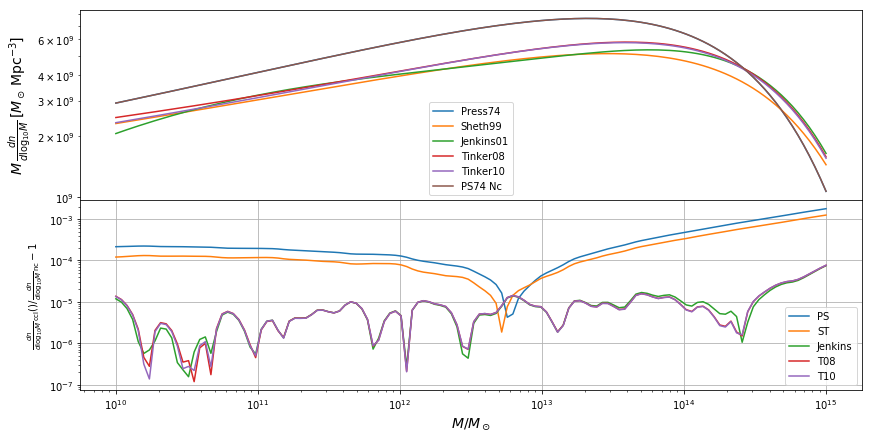

In [20]:
plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14,7))

#CCL
#Press & Schechter
ps = ccl_hmf_PS.get_mass_function(cosmo_ccl, m_arr, 1.0)
ccl_nm_PS = m_arr * ps
axs[0].plot(m_arr, ccl_nm_PS, label=ccl_hmf_PS.name)

#Sheth & Tormen
st = ccl_hmf_ST.get_mass_function(cosmo_ccl, m_arr, 1.0)
ccl_nm_ST = m_arr * st
axs[0].plot(m_arr, ccl_nm_ST, label=ccl_hmf_ST.name)

# Jenkins 2001
jk = ccl_hmf_Jenkins.get_mass_function(cosmo_ccl, m_arr, 1.0)
ccl_nm_Jenkins = m_arr * jk
axs[0].plot(m_arr, ccl_nm_Jenkins, label=ccl_hmf_Jenkins.name)

# Tinker 2008
t08 = ccl_hmf_T08.get_mass_function(cosmo_ccl, m_arr, 1.0)
ccl_nm_T08 = m_arr * t08
axs[0].plot(m_arr, ccl_nm_T08, label=ccl_hmf_T08.name)

# Tinker 2010
t10 = ccl_hmf_T10.get_mass_function(cosmo_ccl, m_arr, 1.0)
ccl_nm_T10 = m_arr * t10
axs[0].plot(m_arr, ccl_nm_T10, label=ccl_hmf_T10.name)

#NumCosmo

#PS
nm_PS = []
for m in m_arr:
    logm = math.log(m)
    nm_PSi = m * mf_PS.dn_dlnM (cosmo, logm, 0.0) * math.log(10.0)
    nm_PS.append(nm_PSi)
   
nm_PS = np.array (nm_PS)    
    
#ST
nm_ST = []
for m in m_arr:
    logm = math.log(m)
    nm_STi = m * mf_ST.dn_dlnM (cosmo, logm, 0.0) * math.log(10.0)
    nm_ST.append(nm_STi)
    
nm_ST = np.array (nm_ST)    
    

#Jenkins
nm_Jenkins = []
for m in m_arr:
    logm = math.log(m)
    nm_Jenkinsi = m * mf_Jenkins.dn_dlnM (cosmo, logm, 0.0) * math.log(10.0)
    nm_Jenkins.append(nm_Jenkinsi)
   
nm_Jenkins = np.array (nm_Jenkins)    

#Tinker 2008
nm_T08 = []
for m in m_arr:
    logm = math.log(m)
    nm_T08i = m * mf_TM08.dn_dlnM (cosmo, logm, 0.0) * math.log(10.0)
    nm_T08.append(nm_T08i)
   
nm_T08 = np.array (nm_T08)    
 
# Tinker 2010 
nm_T10 = []
for m in m_arr:
    logm = math.log(m)
    nm_T10i = m * mf_T10.dn_dlnM (cosmo, logm, 0.0) * math.log(10.0)
    nm_T10.append(nm_T10i)
   
nm_T10 = np.array (nm_T10) 

axs[0].plot (m_arr, nm_PS, label="PS74 Nc")
axs[1].plot (m_arr, np.abs (ccl_nm_PS / nm_PS  - 1.0), '-', label = "PS")
axs[1].plot (m_arr, np.abs (ccl_nm_ST / nm_ST  - 1.0), '-', label = "ST")
axs[1].plot (m_arr, np.abs (ccl_nm_Jenkins / nm_Jenkins  - 1.0), '-', label = "Jenkins")
axs[1].plot (m_arr, np.abs (ccl_nm_T08 / nm_T08  - 1.0), '-', label = "T08")
axs[1].plot (m_arr, np.abs (ccl_nm_T10 / nm_T10  - 1.0), '-', label = "T10")

axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
#axs[0].ylim([1.0E9,8.5E9])
axs[1].set_yscale ('log')
axs[1].set_xlabel(r'$M/M_\odot$', fontsize=14)
axs[0].set_ylabel(r'$M\,\frac{dn}{d\log_{10}M}\,[M_\odot\,{\rm Mpc}^{-3}]$',
           fontsize=14)
axs[1].set_ylabel(r'$\frac{dn}{d\log_{10}M}_{\mathrm{ccl}} () / \frac{dn}{d\log_{10}M}_{\mathrm{nc}} - 1$')


axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[1].grid()


plt.show ()